In [1]:
# plot Lin2d system
import matplotlib.pyplot as plt
import sys, os
sys.path.append('./code_eleves')
import numpy as np
import torch
import torch.nn as nn
from manage_exp import set_tensor_type
from manage_exp import get_x0
from lin2d_exp import get_params

In [25]:
cuda = False #  torch.cuda.is_available()
tensor_type = 'double' # precision numerique
set_tensor_type(tensor_type,cuda)
exp_params = get_params()

use gpu False
use tensor_type double


In [3]:
print('propogator params',exp_params['prop_kwargs'])

propogator params {'loc_classname': 'Lin2d', 'loc_kwargs': {'x_dim': 2, 'N': 1, 'dt': 0, 'init': '0'}, 'gauss_dim': 2, 'scale_vec_classname': 'Cst', 'scale_vec_kwargs': {'init': tensor([-4.6052], dtype=torch.float32)}}


In [4]:
print('observor params',exp_params['obs_kwargs'])

observor params {'loc_classname': 'Id', 'loc_kwargs': {}, 'gauss_dim': 2, 'scale_vec_classname': 'Cst', 'scale_vec_kwargs': {'init': tensor([-2.3026], dtype=torch.float32)}}


In [5]:
# FROM filters
from filters import Cst, Id, GaussianDiag

class ConstructorProp(nn.Module):
    # construct propogator based on prop_kwargs
    # return a Gaussian made from a vector, 
    # this vector is made of the concatnation of loc and scale_vec
    def __init__(self, loc_classname, loc_kwargs,
                 gauss_dim, scale_vec_classname, scale_vec_kwargs):
        nn.Module.__init__(self)       
        self.gauss_dim = gauss_dim # same as x_dim
        self.loc = eval(loc_classname)(**loc_kwargs) # init e.g. Lin2d module
        self.scale_vec = eval(scale_vec_classname)(**scale_vec_kwargs) # Cst module

    def forward(self, *args):
        lc = self.loc(*args)
        sc = self.scale_vec(*args)
        return GaussianDiag(self.gauss_dim, torch.cat((lc, sc), dim=1))        

class ConstructorObs(nn.Module):
    # construct observor based on obs_kwargs
    # return a Gaussian made from a vector, 
    # this vector is made of the concatnation of loc and scale_vec
    def __init__(self, loc_classname, loc_kwargs,
                 gauss_dim=None,
                 scale_vec_classname=None, scale_vec_kwargs=None):
        nn.Module.__init__(self)
        self.gauss_dim = gauss_dim
        self.loc = eval(loc_classname)(**loc_kwargs) # init e.g. Id module
        self.scale_vec = eval(scale_vec_classname)(**scale_vec_kwargs) # Cst module       
    def forward(self, *args):
        lc = self.loc(*args)
        sc = self.scale_vec(*args)
        return GaussianDiag(self.gauss_dim, torch.cat((lc, sc), dim=1))    

In [6]:
# TO modify in filters
class Lin2d(nn.Module):
    # rotation dymnamics
    def __init__(self, x_dim, N, dt, init,
                 window=None):
        assert(x_dim == 2)
        nn.Module.__init__(self)        
        theta = np.pi / 100        
        linM = torch.Tensor([[np.cos(theta),np.sin(theta)],
                             [-np.sin(theta),np.cos(theta)]])
        self.linM = linM
        self.linMt = linM.t()
        self.x_dim = x_dim
        self.N = N
        
    def forward(self, x):
        for _ in range(self.N):            
            x = torch.matmul(x, self.linMt)
        return x

empirical mean of x0 is tensor([2.9886, 2.9991])


(-4.0, 4.0)

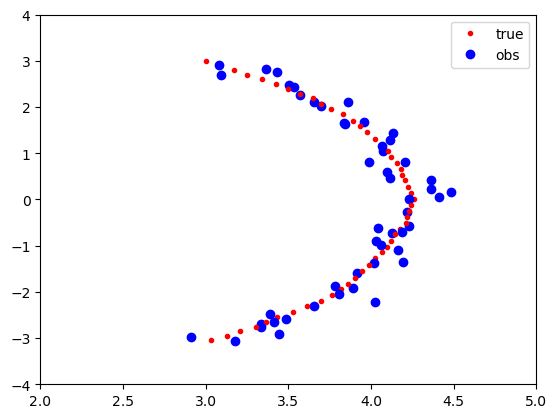

In [22]:
train_kwargs = exp_params['train_kwargs']
prop_kwargs = exp_params['prop_kwargs']
obs_kwargs = exp_params['obs_kwargs']
prop = ConstructorProp(**prop_kwargs)
obs = ConstructorObs(**obs_kwargs)

b_size = 2 # train_kwargs['b_size']
h_dim = train_kwargs['h_dim']
x_dim = train_kwargs['x_dim']
T = 50 # train_kwargs['T']

sigma = exp_params['sigma0']
x0 = get_x0(b_size, x_dim, sigma)
xt = [None]
yt = [None]
x = x0

# PLOT first trajectory
sample_idx = 0
plt.plot(x0[sample_idx,0].item(),x0[sample_idx,1].item(),'r.')
for t in range(1,T+1):
    x = prop(x)\
            .sample(sample_shape=torch.Size([1]))\
            .squeeze(0)
    y = obs(x)\
            .sample(sample_shape=torch.Size([1]))\
            .squeeze(0)
    xt.append(x)
    yt.append(y)
    plt.plot(y[sample_idx,0].item(),y[sample_idx,1].item(),'bo')
    plt.plot(x[sample_idx,0].item(),x[sample_idx,1].item(),'r.')

plt.legend(['true','obs'])
print('empirical mean of x0 is', torch.mean(x0,0))
plt.xlim([2,5])
plt.ylim([-4,4])

(-4.0, 4.0)

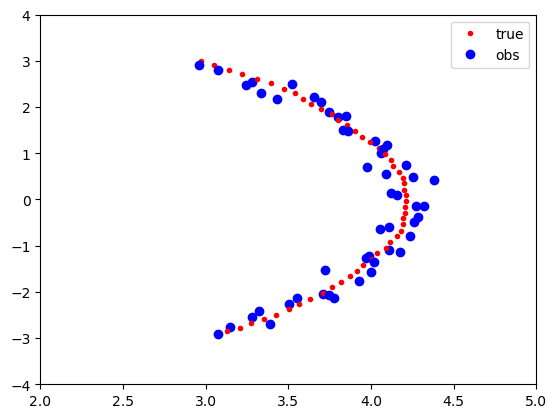

In [24]:
# PLOT second trajectory
sample_idx = 1
plt.plot(x0[sample_idx,0].item(),x0[sample_idx,1].item(),'r.')
for t in range(1,T+1):
    x = xt[t]
    y = yt[t]
    plt.plot(y[sample_idx,0].item(),y[sample_idx,1].item(),'bo')
    plt.plot(x[sample_idx,0].item(),x[sample_idx,1].item(),'r.')

plt.legend(['true','obs'])
plt.xlim([2,5])
plt.ylim([-4,4])